In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_dir  = '/content/drive/MyDrive/Garbage classification/Garbage classification/'

classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


---------------------------------------------

## 파일 불러오기

In [7]:
import os, cv2, pandas as pd, numpy as np

# General Path
path = "/content/drive/MyDrive/Garbage classification/Garbage classification/"

# List of paths 
file_list = []
file_list.append(os.listdir(f"{path}cardboard"))
file_list.append(os.listdir(f"{path}glass"))
file_list.append(os.listdir(f"{path}metal"))
file_list.append(os.listdir(f"{path}paper"))
file_list.append(os.listdir(f"{path}plastic"))
file_list.append(os.listdir(f"{path}trash"))

# List of classes
class_names=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

X = []
y = []

# Count all images
contImages = 0


for classes_files, classe in zip (file_list, range(6)):
  for i in range(len(classes_files)):
    name = str(path) + str(class_names[classe]) + str('/') + str(classes_files[i]) 
    imagem = cv2.imread(name)
    b, g, r = cv2.split((imagem))
    imagem = cv2.merge([r,g,b])
    imagem = cv2.resize(imagem, (224, 224))  # <-- 이미지 크기를 (224,224)로 맞춰줌
    img = np.asarray(imagem)
    y.append(classe)      
    X.append(img)
    contImages += 1

# Saving the in a csv file
np.save('X', X)

# Saving the classes in a csv file
df_class = pd.DataFrame(y)
df_class.to_csv('y.csv', header=False, index=False)

print(f"Number of images: {contImages}")

Number of images: 2527


In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


# Scale pixels
def prep_pixels(train, test):
	# Convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# Normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# Return normalized images
	return train_norm, test_norm

# Load the images and the corresponding labels
y = pd.read_csv('y.csv', header=None)
y = y.to_numpy()
y = np.ravel(y)
X = np.load('X.npy')


In [9]:
X.shape

(2527, 224, 224, 3)

In [10]:
y.shape

(2527,)

In [11]:
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_od8oazl
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-_od8oazl
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180173 sha256=980e00994a82c928ea2a01d9c40ae0826a403cf384731124b0b666fd3985ef14
  Stored in directory: /tmp/pip-ephem-wheel-cache-7d8wqsan/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [12]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio

In [31]:
batch_size = 32
num_channels = 3
num_classes = 6
image_size = 224
latent_dim = 128

In [32]:
all_digits = X.astype("float32") / 255.0  # 0 ~ 1 사이로 픽셀 스케일링
all_labels = to_categorical(y, 6) # label을 one-hot encoding

In [33]:
all_digits.shape

(2527, 224, 224, 3)

In [34]:
all_labels.shape

(2527, 6)

In [35]:
# tf.data.Dataset로 만들어준다. 
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (2527, 224, 224, 3)
Shape of training labels: (2527, 6)


In [36]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

134 9


In [64]:
# discriminator
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((224, 224, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),
     
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),
     
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),
     
        layers.GlobalMaxPooling2D(),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
     
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"), # 최종 (224,224)가 되도록 4*4 conv2d 레이어 배열 
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(alpha=0.2),
     
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(alpha=0.2),
     
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(alpha=0.2),
     
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(alpha=0.2),
     
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(alpha=0.2),
     
        layers.Conv2D(3, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)
discriminator.summary()
generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 112, 112, 64)      5248      
                                                                 
 batch_normalization_45 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, 112, 112, 64)      0         
                                                                 
 dropout_15 (Dropout)        (None, 112, 112, 64)      0         
                                                                 
 conv2d_41 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 conv2d_42 (Conv2D)          (None, 28, 28, 128)       147584    
                                                     

In [65]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
       
        real_images, one_hot_labels = data # 데이터 이미지와 라벨 지정

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim)) # fake image 생성을 위해 랜덤 벡터 생성
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1 # latent벡터와 label 병합
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels) # label을 추가해 만든 노이즈로 이미지 생성

        # Image와 label concat/ real과 fake concat
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1) # fake
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1) # real
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0  # 실제와 fake 병합
        )

        # Discriminator에서 real or fake 구분하는 label 생성
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0 
        )

        # Train the discriminator.
        with tf.GradientTape() as tape: # gradient 자동미분 -> weight 갱신
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


##  모형 피팅

In [66]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=100)

Epoch 1/100
79/79 [==============================] - 35s 382ms/step - g_loss: 2.1478 - d_loss: 0.4849
Epoch 2/100
79/79 [==============================] - 30s 379ms/step - g_loss: 9.3146 - d_loss: 0.0143
Epoch 3/100
79/79 [==============================] - 30s 380ms/step - g_loss: 9.3604 - d_loss: 0.0014
Epoch 4/100
79/79 [==============================] - 30s 380ms/step - g_loss: 10.7466 - d_loss: 7.3685e-04
Epoch 5/100
79/79 [==============================] - 30s 380ms/step - g_loss: 10.9575 - d_loss: 0.0122
Epoch 6/100
79/79 [==============================] - 30s 380ms/step - g_loss: 3.8183 - d_loss: 0.6618
Epoch 7/100
79/79 [==============================] - 30s 380ms/step - g_loss: 10.0583 - d_loss: 0.4640
Epoch 8/100
79/79 [==============================] - 30s 380ms/step - g_loss: 4.6995 - d_loss: 0.1215
Epoch 9/100
79/79 [==============================] - 30s 380ms/step - g_loss: 4.6826 - d_loss: 0.3737
Epoch 10/100
79/79 [==============================] - 30s 379ms/step - g_lo

### 이미지 생성

In [67]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation =   1# @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 1  # @param {type:"slider", min:0, max:9, step:1}
end_class = 1  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)


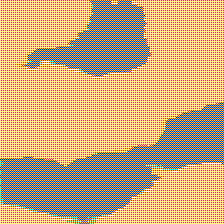

In [68]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (224, 224)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images, fps=1)
embed.embed_file("animation.gif")